In [16]:
import datetime
import os
import random
import pandas as pd

import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.utils import shuffle

from fedot.core.composer.chain import Chain
from fedot.core.composer.gp_composer.gp_composer import GPComposerRequirements, GPComposerBuilder
from fedot.core.composer.optimisers.gp_optimiser import GPChainOptimiserParameters, GeneticSchemeTypesEnum
from fedot.core.composer.visualisation import ComposerVisualiser
from fedot.core.models.data import InputData, OutputData
from fedot.core.repository.model_types_repository import ModelTypesRepository
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum, MetricsRepository
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.utils import project_root

In [17]:
dataset = pd.read_csv('ionosphere.csv', header = None )

In [18]:
dataset  = shuffle(dataset )

In [19]:
df_train = dataset[:280]
df_test = dataset[280:]

In [20]:
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

Импортируем данные.

In [21]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

In [22]:
#file_path_train = 'scoring_train.csv'
#file_path_test = 'scoring_test.csv'

Очень важно задать ограничение по времени. 
Оно задается с использлванием страндартной библиотеки datetime.

In [23]:
 max_lead_time: datetime.timedelta = datetime.timedelta(minutes=5)

Выбор задачи, в нашем случае это задача классификации.

In [24]:
task = Task(TaskTypesEnum.classification)

Преобразуем данные в такой вид, с которым фреймворку будет удобно и корректно работать.

In [25]:
dataset_to_compose = InputData.from_csv(train_file_path, task=task)
dataset_to_validate = InputData.from_csv(test_file_path, task=task)

Импорт моделей из репозитория.
В данном случае возьмем для составления цепочек используем возможные модели предназначенные для классификации.

In [26]:
 available_model_types, _ = ModelTypesRepository().suitable_model(task_type=task.task_type)

Определение метрики для оценки качества моделей.

In [27]:
metric_function = MetricsRepository().metric_by_id(ClassificationMetricsEnum.ROCAUC)

Определение ресурсов для композера.

In [28]:
composer_requirements = GPComposerRequirements(
        primary=available_model_types,
        secondary=available_model_types, max_arity=3,
        max_depth=3, pop_size=10, num_of_generations=10,
        crossover_prob=0.8, mutation_prob=0.8, max_lead_time=max_lead_time, add_single_model_chains= False)

Выбор параметров оптимизатора. 

Здесь в основном задаются типы операторов которые будут использльзоваться в алгоритме оптимизации: схема эволюции, тип селекции, скрещивания, мутации, регуляризации и т. д.)

Мы задаем нужную эволюционную схему, остальные же параметры оставляем по умолчанию.

In [29]:
scheme_type = GeneticSchemeTypesEnum.steady_state
optimiser_parameters = GPChainOptimiserParameters(genetic_scheme_type=scheme_type)

Создание билдера, который конструирует композер учитывая все параметры, которые мы задали.
Обратите внимание, в билдер параметры передаются с использование функции with_parameter(parameter_type).

In [30]:
builder = GPComposerBuilder(task=task).with_requirements(composer_requirements).with_metrics(
        metric_function).with_optimiser_parameters(optimiser_parameters)

composer = builder.build()

Запуск алгоритма копозирования который мы составили путем выбора и передачи всех желаемых параметров.

In [31]:
chain_evo_composed = composer.compose_chain(data=dataset_to_compose,
                                            is_visualise=False)

Generation num: 0
max_depth: 3, no improvements: 1
spent time: 0.1 min
Best metric is -0.995
Generation num: 1
max_depth: 3, no improvements: 1
spent time: 0.1 min
Best metric is -0.995
Generation num: 2
max_depth: 3, no improvements: 1
spent time: 0.2 min
Best metric is -0.995
Generation num: 3
max_depth: 3, no improvements: 1
spent time: 0.2 min
Best metric is -0.995
Generation num: 4
max_depth: 3, no improvements: 1
spent time: 0.3 min
Best metric is -0.995
Generation num: 5
max_depth: 3, no improvements: 1
spent time: 0.4 min
Best metric is -0.995
Generation num: 6
max_depth: 3, no improvements: 1
spent time: 0.4 min
Best metric is -0.996
Generation num: 7
max_depth: 3, no improvements: 1
spent time: 0.5 min
Best metric is -0.998
Generation num: 8
max_depth: 3, no improvements: 1
spent time: 0.8 min
Best metric is -0.998
Composition time: 0.75 min
GP composition finished


In [34]:
def calculate_validation_metric(chain: Chain, dataset_to_validate: InputData) -> float:
    # the execution of the obtained composite models
    predicted = chain.predict(dataset_to_validate)
    # the quality assessment for the simulation results
    roc_auc_value = roc_auc(y_true=dataset_to_validate.target,
                            y_score=predicted.predict)
    return roc_auc_value

Trying to fit secondary node with model: xgboost
Fit all parent nodes in secondary node with model: xgboost


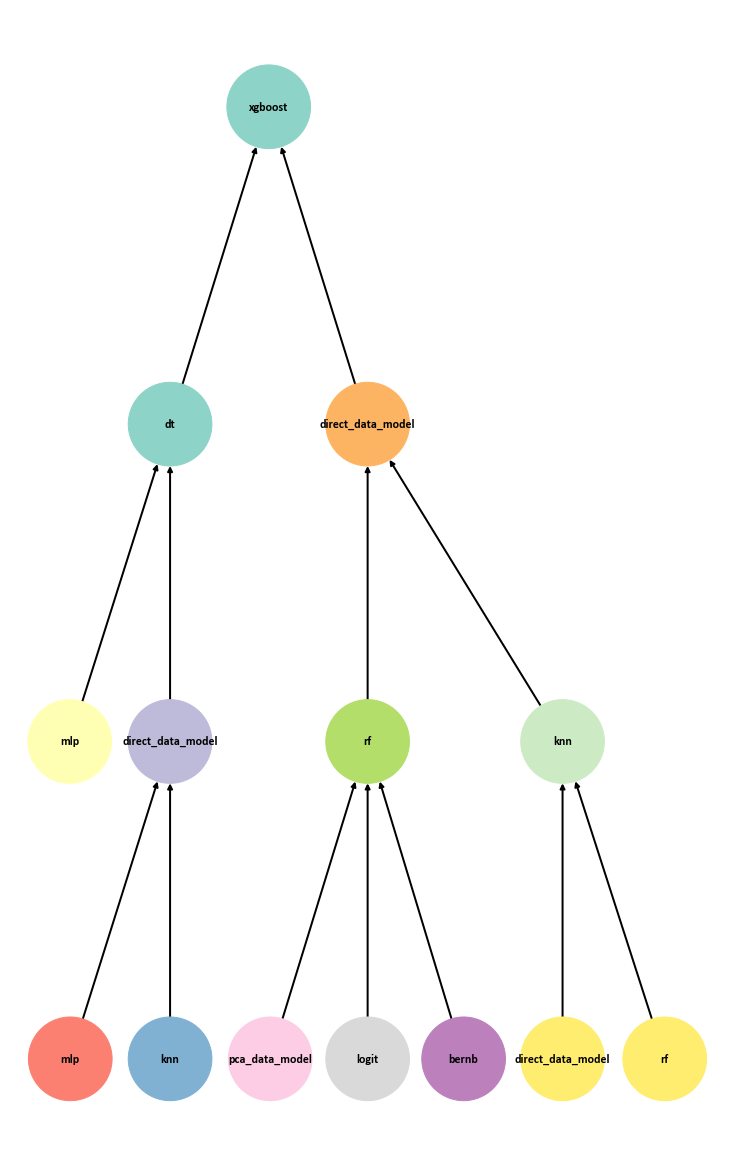

Composed ROC AUC is 0.994


In [35]:
chain_evo_composed.fit(input_data=dataset_to_compose, verbose=True)


ComposerVisualiser.visualise(chain_evo_composed)

# the quality assessment for the obtained composite models
roc_on_valid_evo_composed = calculate_validation_metric(chain_evo_composed,
                                                        dataset_to_validate)

print(f'Composed ROC AUC is {round(roc_on_valid_evo_composed, 3)}')